In [21]:
import json
from pathlib import Path

import matplotlib.pyplot as plt

import matplotlib.ticker as mticker
import numpy as np

metric_files = {
    "base_qrl": "/home/hkppp/Classes/naht/naht_results/mpe-pp/open_train/poam-qrl_open_baselines/sacred/poam_baseline_seed=112358_11-29-03-34-29/1/metrics.json",
    "mod_qrl": "/home/hkppp/Classes/naht/naht_results/mpe-pp/open_train/poam-qrl_open/sacred/poam_baseline_seed=112358_12-02-02-56-04/1/metrics.json", # modified qrl run
    "poam_base": "/home/hkppp/Classes/naht/naht_results/mpe-pp/open_train/poam-pqvmq_open/sacred/poam_baseline_seed=112358_12-02-11-36-28/1/metrics.json"
}
    


all_runs = {}

for label, path_str in metric_files.items():
    path = Path(path_str)
    with path.open() as f:
        metrics = json.load(f)
    all_runs[label] = metrics

all_runs.keys()

dict_keys(['base_qrl', 'mod_qrl', 'poam_base'])

In [22]:


def plot_metric_across_runs(metric_name, runs_dict,
                            clip_to_min_steps=False,
                            max_points=25,          # max points per curve (None = no limit)
                            figsize=(8, 5)):
    """
    Plot one metric across multiple runs on the same graph.

    runs_dict: {run_label: metrics_dict}
    metrics_dict[metric_name] is expected to look like:
        {
            "steps": [...],
            "values": [...]
        }
    """
    plt.figure(figsize=figsize)

    min_steps = None
    if clip_to_min_steps:
        lengths = []
        for metrics in runs_dict.values():
            metric = metrics.get(metric_name)
            if metric is None:
                continue
            steps = metric["steps"]
            values = metric["values"]
            lengths.append(min(len(steps), len(values)))

        if not lengths:
            print(f"No run contains metric '{metric_name}'")
            plt.close()
            return

        min_steps = min(lengths)

    found_any = False
    for run_label, metrics in runs_dict.items():
        if metric_name not in metrics:
            continue

        steps = np.array(metrics[metric_name]["steps"])
        values = np.array(metrics[metric_name]["values"])

        if clip_to_min_steps:
            steps = steps[:min_steps]
            values = values[:min_steps]

        # Downsample if too many points
        if max_points is not None and len(steps) > max_points:
            idx = np.linspace(0, len(steps) - 1, max_points, dtype=int)
            steps = steps[idx]
            values = values[idx]

        plt.plot(steps, values, label=run_label, linewidth=2)  # no markers
        found_any = True

    if not found_any:
        print(f"No run contains metric '{metric_name}'")
        plt.close()
        return

    ax = plt.gca()
    ax.xaxis.set_major_locator(mticker.MaxNLocator(6))  # fewer x-ticks

    plt.xlabel("Steps")
    plt.ylabel(metric_name)
    plt.title(metric_name)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [23]:
# Collect all metric names that appear in any run
all_metric_names = set()
for metrics in all_runs.values():
    all_metric_names.update(metrics.keys())

sorted(all_metric_names)


['actor_grad_norm',
 'actor_loss',
 'advantage_mean',
 'critic_grad_norm',
 'critic_loss',
 'curr_taken_v',
 'ed_act_loss',
 'ed_grad_norm',
 'ed_loss',
 'ed_obs_loss',
 'entropy',
 'episode',
 'log_pi_taken',
 'old_values_mean',
 'ratio',
 'target_mean',
 'td_error_abs',
 'test_ep_length_mean',
 'test_return_mean',
 'test_return_std',
 'train_ep_length_mean',
 'train_return_mean',
 'train_return_std']

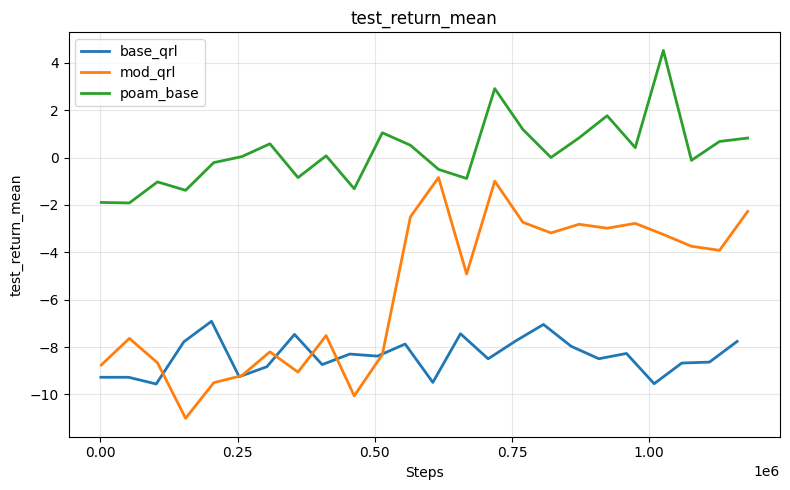

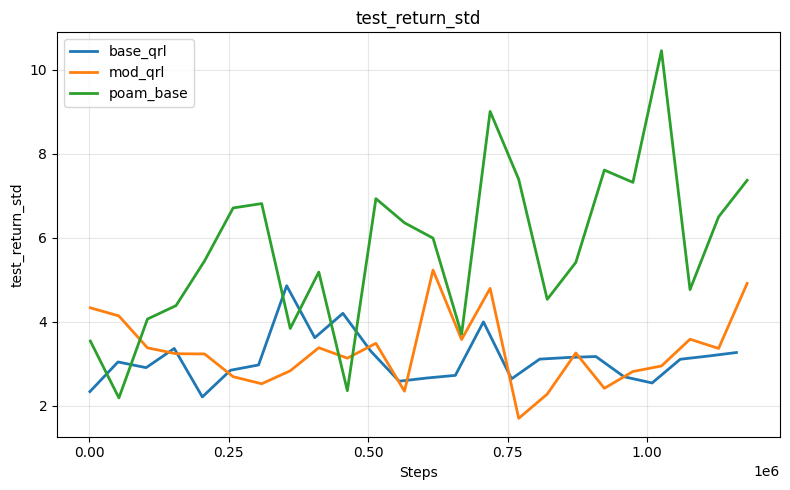

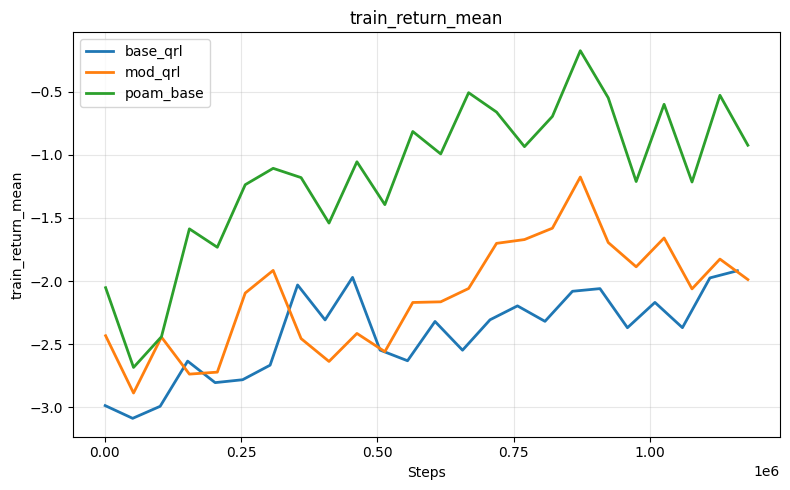

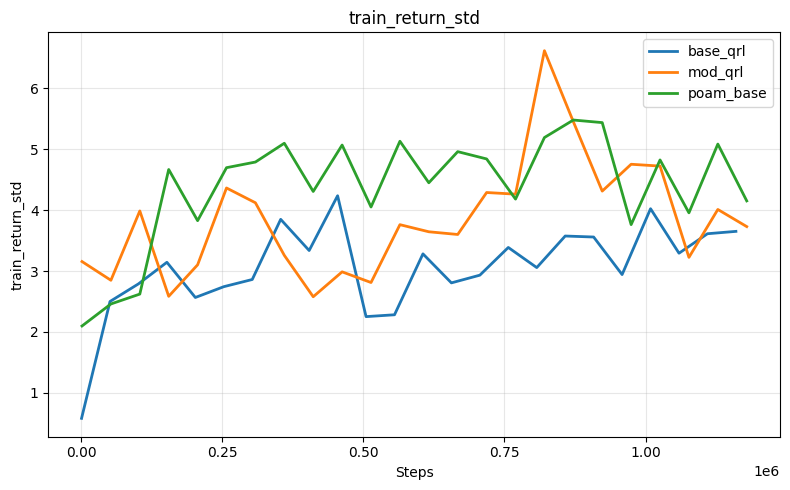

In [24]:
# Plot each metric across runs
selected_metric_names = ['test_return_mean', 'test_return_std', 'train_return_mean', 'train_return_std']
for metric_name in sorted(selected_metric_names):
    plot_metric_across_runs(metric_name, all_runs, clip_to_min_steps=True)


In [ ]:


def plot_mean_with_std_across_runs(
    mean_metric_name,
    std_metric_name,
    runs_dict,
    clip_to_min_steps=False,
    max_points=25,          # max points per curve (None = no limit)
    figsize=(8, 5)
):
    """
    Plot mean metric with a std spread (mean ± std) for multiple runs.

    runs_dict: {run_label: metrics_dict}
    metrics_dict[metric_name] should look like:
        {
            "steps": [...],
            "values": [...]
        }
    """
    plt.figure(figsize=figsize)

    # Determine common length if requested
    min_steps = None
    if clip_to_min_steps:
        lengths = []
        for metrics in runs_dict.values():
            mean_m = metrics.get(mean_metric_name)
            std_m = metrics.get(std_metric_name)
            if mean_m is None or std_m is None:
                continue
            steps = mean_m["steps"]
            mean_vals = mean_m["values"]
            std_vals = std_m["values"]
            lengths.append(min(len(steps), len(mean_vals), len(std_vals)))

        if not lengths:
            print(f"No run contains both '{mean_metric_name}' and '{std_metric_name}'")
            plt.close()
            return

        min_steps = min(lengths)

    found_any = False
    for run_label, metrics in runs_dict.items():
        if mean_metric_name not in metrics or std_metric_name not in metrics:
            continue

        steps = np.array(metrics[mean_metric_name]["steps"])
        mean_vals = np.array(metrics[mean_metric_name]["values"])
        std_vals = np.array(metrics[std_metric_name]["values"])

        # Clip to minimal shared length if needed
        if clip_to_min_steps:
            steps = steps[:min_steps]
            mean_vals = mean_vals[:min_steps]
            std_vals = std_vals[:min_steps]

        # Downsample to avoid clutter
        if max_points is not None and len(steps) > max_points:
            idx = np.linspace(0, len(steps) - 1, max_points, dtype=int)
            steps = steps[idx]
            mean_vals = mean_vals[idx]
            std_vals = std_vals[idx]

        upper = mean_vals + std_vals
        lower = mean_vals - std_vals

        # Shaded std region (faint, no legend entry)
        plt.fill_between(steps, lower, upper, alpha=0.15, linewidth=0, label="_nolegend_")

        # Mean line
        plt.plot(steps, mean_vals, linewidth=2, label=run_label)

        found_any = True

    if not found_any:
        print(f"No run contains both '{mean_metric_name}' and '{std_metric_name}'")
        plt.close()
        return

    ax = plt.gca()
    ax.xaxis.set_major_locator(mticker.MaxNLocator(6))

    plt.xlabel("Steps")
    plt.ylabel(mean_metric_name)
    plt.title(f"{mean_metric_name} with {std_metric_name} spread")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


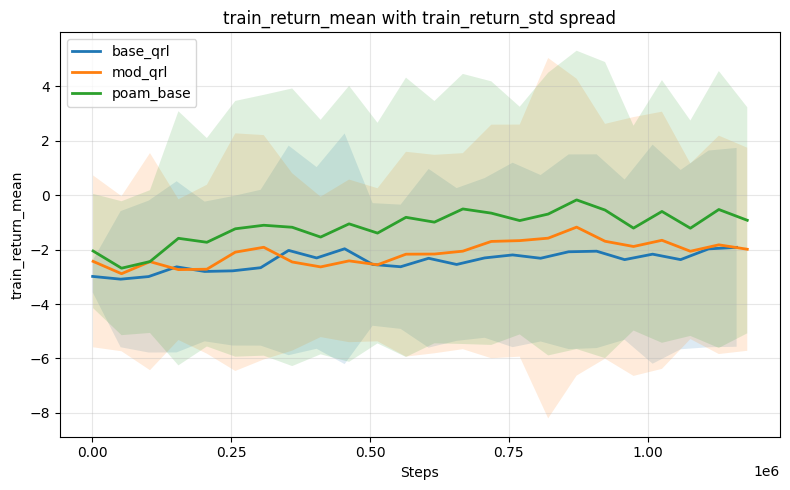

In [28]:
plot_mean_with_std_across_runs(
    mean_metric_name="train_return_mean",
    std_metric_name="train_return_std",
    runs_dict=all_runs,
    clip_to_min_steps=True,
    max_points=None
)

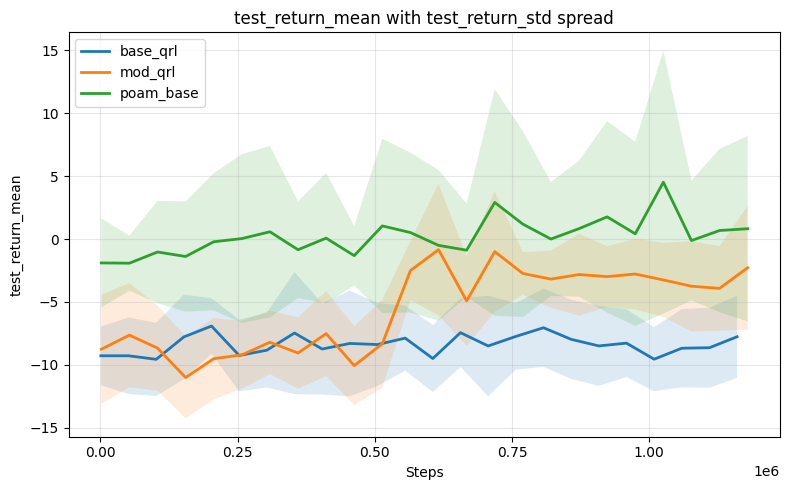

In [29]:
plot_mean_with_std_across_runs(
    mean_metric_name="test_return_mean",
    std_metric_name="test_return_std",
    runs_dict=all_runs,
    clip_to_min_steps=True,
    max_points=None
)